<a href="https://colab.research.google.com/github/ArunPrasath1205/Retail-Sales-Prediction-ML-Project/blob/main/Part_2_Rossmann_sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$Note:$
* This is the 2nd Colab file, Continuing from previous one which left due to Lack of RAM memory.

$Previously..$ 
* We have completed till Creating and Evaluating our Baseline Model (Decision Tree)

$Now..$
* We try to create model our data in another algorithm.
* Later we compare the metrics of each algorithm and find the best one to predict our data.

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np

# Importing for visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing Datatime 
from datetime import datetime

# Importing warnings to import
import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Importing Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

In [4]:
# Importing Evaluation metrics 

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [5]:
# Importing Google Drive

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [17]:
# Reading CSV files we already stored previously.

df = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/df_cleaned.csv", parse_dates=['Date'])
comparison_df = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/dt_results.csv")


In [10]:
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Year,month,dayofyear,weekofyear,CompetitionOpened,Promo2Open
0,2013-01-01,85,2,8.347590,619,1,0,1,1,b,a,1870.0,0,0.0,2013,1,1,1,15.0,0.0
1,2013-01-01,259,2,8.832150,1444,1,0,1,1,b,b,210.0,0,0.0,2013,1,1,1,42.0,0.0
2,2013-01-01,262,2,9.756552,2875,1,0,1,1,b,a,1180.0,0,0.0,2013,1,1,1,0.0,0.0
3,2013-01-01,274,2,8.039802,729,1,0,1,1,b,b,3640.0,1,0.0,2013,1,1,1,42.0,0.0
4,2013-01-01,335,2,7.783641,482,1,0,1,1,b,a,90.0,1,0.0,2013,1,1,1,42.0,0.0


In [18]:
#setting date and store as index

df.set_index(['Date','Store'],inplace=True)

#sorting index following the time series

df.sort_index(inplace=True)

In [19]:
df.head()

DayOfWeek     Sales  Customers  Open  Promo  StateHoliday  \
Date       Store                                                              
2013-01-01 85             2  8.347590        619     1      0             1   
           259            2  8.832150       1444     1      0             1   
           262            2  9.756552       2875     1      0             1   
           274            2  8.039802        729     1      0             1   
           335            2  7.783641        482     1      0             1   

                  SchoolHoliday StoreType Assortment  CompetitionDistance  \
Date       Store                                                            
2013-01-01 85                 1         b          a               1870.0   
           259                1         b          b                210.0   
           262                1         b          a               1180.0   
           274                1         b          b               3640.0   
           335                1         b          a                 90.0   

                  Promo2  PromoInterval  Year  month  dayofyear  weekofyear  \
Date       Store                                                              
2013-01-01 85          0            0.0  2013      1          1           1   
           259         0            0.0  2013      1          1           1   
           262         0            0.0  2013      1          1           1   
           274         1            0.0  2013      1          1           1   
           335         1            0.0  2013      1          1           1   

                  CompetitionOpened  Promo2Open  
Date       Store                                 
2013-01-01 85                  15.0         0.0  
           259                 42.0         0.0  
           262                  0.0         0.0  
           274                 42.0         0.0  
           335                 42.0         0.0

In [20]:
#Spliting the data for the logic explained above.

#train

start_train = pd.to_datetime("2013-01-01")
end_train = pd.to_datetime("2015-06-14")
df_train = df.loc[start_train:end_train]

#test

start_test = pd.to_datetime("2015-06-15")
end_test = pd.to_datetime("2015-07-31")
df_test = df.loc[start_test:end_test]

In [21]:
# Creating the Separate variable called X_train, y_train from "df_train" dataset.
# Creating the Separate variable called X_test, y_test from "df_test" dataset.

X_train = df_train.drop('Sales',axis=1)
y_train = df_train[['Sales']]
X_test = df_test.drop('Sales',axis=1)
y_test = df_test[['Sales']]
print(f'The shape of X_train is: {X_train.shape}')
print(f'The shape of y_train is: {y_train.shape}')
print(f'The shape of X_test is: {X_test.shape}')
print(f'The shape of y_test is: {y_test.shape}')

The shape of X_train is: (798486, 17)
The shape of y_train is: (798486, 1)
The shape of X_test is: (45852, 17)
The shape of y_test is: (45852, 1)


In [22]:
# Applying one hot encoder for listed Catergorical variable 
# Then Removing those categorical variable after encoding is done.

#Importing onehotencoder

from sklearn.preprocessing import OneHotEncoder

#categorical features to be encoded.

categorical_cols = ['DayOfWeek', 'StoreType', 'Assortment']

#fitting encoder

encoder = OneHotEncoder(sparse=False)

# training

encoder.fit(X_train[categorical_cols])
encoded_features = list(encoder.get_feature_names(categorical_cols))
X_train[encoded_features] = encoder.transform(X_train[categorical_cols])

# testing

X_test[encoded_features] = encoder.transform(X_test[categorical_cols])

# droping original features

X_train.drop(categorical_cols,axis=1,inplace=True)
X_test.drop(categorical_cols,axis=1,inplace=True)

In [23]:
# Scaling of the Splitted Data.
# We using StandardScaler for Scaling the data.
# Scaling both Training and Testing Data.

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train[list(X_train.columns)] = stdsc.fit_transform(X_train[list(X_train.columns)])
X_test[list(X_test.columns)] = stdsc.transform(X_test[list(X_test.columns)])

scaler = StandardScaler()
y_train[list(y_train.columns)] = scaler.fit_transform(y_train[list(y_train.columns)])
y_test[list(y_test.columns)] = scaler.transform(y_test[list(y_train.columns)])

## Modeling - Random Forest Regressor

In [24]:
random_forest = RandomForestRegressor(n_estimators=100,random_state=42)
random_forest.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [26]:
#Creating the Function to evaluate the model
def model_evaluation(model_name,model_variable,X_train,y_train,X_test,y_test):
  ''' This function predicts and evaluates various models for regression algorithms, visualizes results 
      and creates a dataframe that compares the various models.'''
      
  #making predictions
  y_pred_train = model_variable.predict(X_train)
  y_pred_test = model_variable.predict(X_test)

  # Plot the test results
  a = y_test.copy()
  a['Pred Sales'] = y_pred_test.tolist()
  df_plot = a.reset_index(level=['Date'])
  plot = df_plot.groupby('Date')['Sales','Pred Sales'].sum()
  sns.lineplot(data = plot)
  plt.ylabel("Total Sales and Predicted Sales")
  plt.xticks(rotation = 25)

  #calculate metrics and print the results for test set
  
  #Mean Absolute Error or MAE
  
  MAE_train = round(mean_absolute_error(y_train,y_pred_train),6)
  MAE_test = round(mean_absolute_error(y_test,y_pred_test),6)
  
  #Mean Squared Error or MSE
  
  MSE_train = round(mean_squared_error(y_train,y_pred_train),6)
  MSE_test = round(mean_squared_error(y_test,y_pred_test),6)
  
  #Root Mean Squared Error or RMSE
  
  RMSE_train = round(mean_squared_error(y_train,y_pred_train,squared=False),6)
  RMSE_test = round(mean_squared_error(y_test,y_pred_test,squared=False),6)
  
  #R2
  
  R2_train = round(r2_score(y_train, y_pred_train),6)
  R2_test = round(r2_score(y_test, y_pred_test),6)
  
  #Adjusted R2
  Adj_r2_train = round(1 - (1-r2_score(y_train, y_pred_train)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1),6)
  Adj_r2_test = round(1 - (1-r2_score(y_test, y_pred_test)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),6)
  
  #printing test results
  print(f'The Mean Absolute Error for the validation set is {MAE_test}')
  print(f'The Mean Squared Error for the validation set is {MSE_test}')
  print(f'The Root Mean Squared Error for the validation set is {RMSE_test}')
  print(f'The R^2 for the validation set is {R2_test}')
  print(f'The Adjusted R^2 for the validation set is {Adj_r2_test}')

  #Saving our results
  global comparison_columns
  metric_scores = [model_name,MAE_train,MSE_train,RMSE_train,R2_train,Adj_r2_train,MAE_test,MSE_test,RMSE_test,R2_test,Adj_r2_test]
  final_dict = dict(zip(comparison_columns,metric_scores))
  return [final_dict]

In [27]:
#Creating the function to create the comparison table
final_list = []
def add_list_to_final_df(dict_list):
  global final_list
  for elem in dict_list:
    final_list.append(elem)
  global comparison_df
  comparison_df = pd.DataFrame(final_list, columns= comparison_columns)

In [28]:
# Columns names in the Metrics comparision Table.

comparison_columns = ['Model_Name', 'Train_MAE', 'Train_MSE', 'Train_RMSE', 'Train_R2', 'Train_Adj_R2' ,'Test_MAE', 'Test_MSE', 'Test_RMSE', 'Test_R2', 'Test_Adj_R2']


The Mean Absolute Error for the validation set is 0.14187
The Mean Squared Error for the validation set is 0.035382
The Root Mean Squared Error for the validation set is 0.1881
The R^2 for the validation set is 0.962439
The Adjusted R^2 for the validation set is 0.962416


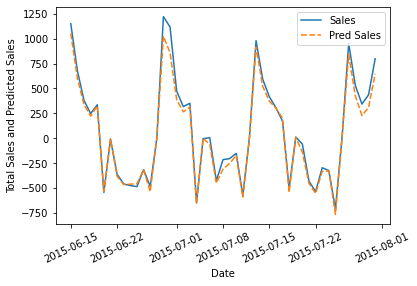

In [29]:
#Decision tree evaluation

random_f = model_evaluation('Random Forest Regressor',random_forest,X_train,y_train,X_test,y_test)

In [30]:
# Add result to comparision_df
add_list_to_final_df(random_f)

In [31]:
# Importing Metrics Comparision Table from previous file

comparison_df1 = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/dt_results.csv")
comparison_df1

,Unnamed: 0,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,0,Decision Tree Regressor,0.000004,0.000001,0.001098,0.999999,0.999999,0.197009,0.073922,0.271887,0.921524,0.921476


In [32]:
comparison_df2 = comparison_df
comparison_df2

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Random Forest Regressor,0.043688,0.003573,0.059772,0.996427,0.996427,0.14187,0.035382,0.1881,0.962439,0.962416


In [33]:
# Combining the Evaluation metrics for both algorithms. 

result = comparison_df1.append(comparison_df2)
result.drop(columns = "Unnamed: 0", axis = 1, inplace = True)
#result.set_index("Model_Name", inplace = True)
display(result)

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Decision Tree Regressor,0.000004,0.000001,0.001098,0.999999,0.999999,0.197009,0.073922,0.271887,0.921524,0.921476
0,Random Forest Regressor,0.043688,0.003573,0.059772,0.996427,0.996427,0.141870,0.035382,0.188100,0.962439,0.962416


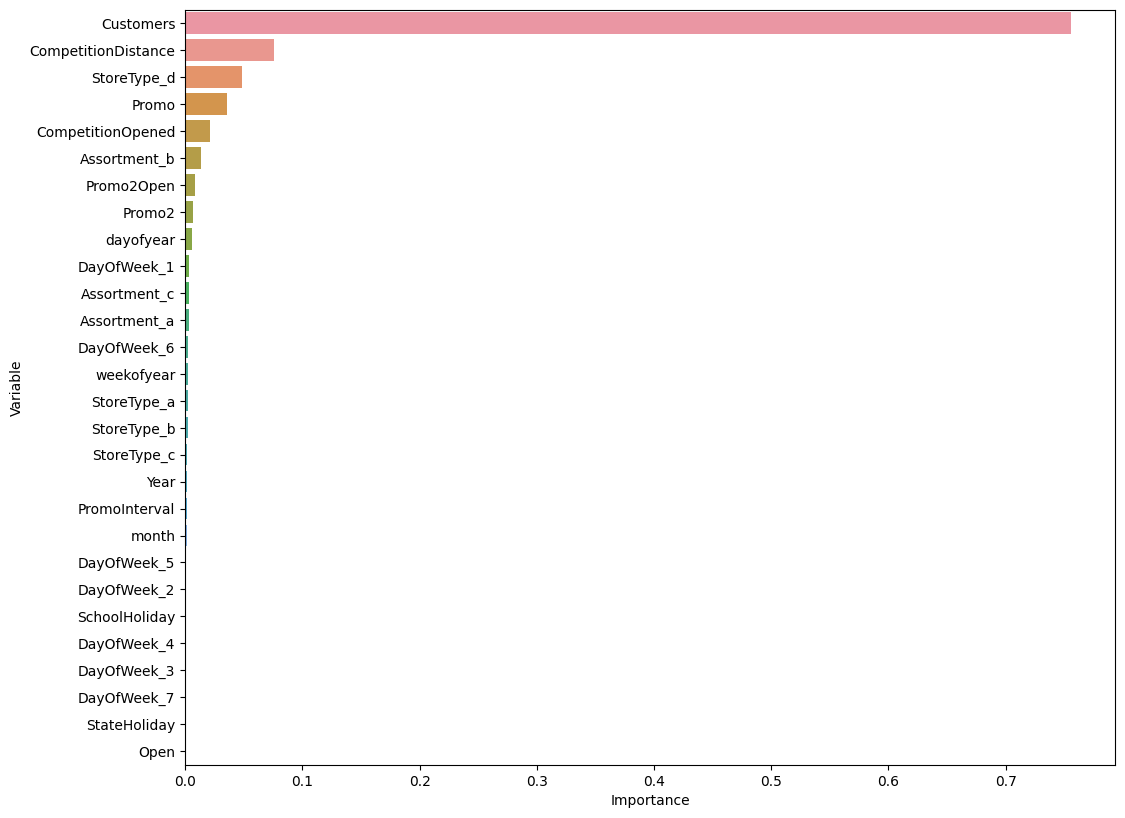

In [35]:
#visualising feature importance of XGB

feature_imp = pd.DataFrame({"Variable": X_test.columns,"Importance": random_forest.feature_importances_})
feature_imp.sort_values(by="Importance", ascending=False, inplace = True)
sns.barplot(x=feature_imp['Importance'], y= feature_imp['Variable'])
plt.rcParams.update({'figure.figsize':(12,15),'figure.dpi':100})

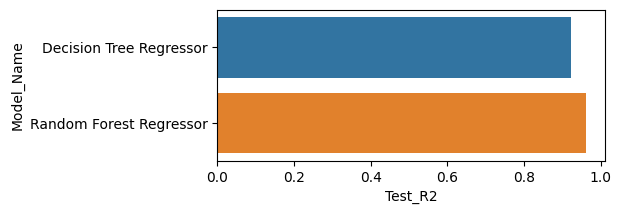

In [51]:
#visualising our comparison df for Test R2

sns.barplot(y=result['Model_Name'], x = result['Test_R2'])
plt.rcParams.update({'figure.figsize':(2,2),'figure.dpi':100})

## Decision Tree Vs Random Forest


In [37]:
# Creating the variables for r2 score 

decision_tree_r2 = 0.921358
random_forest_r2 = 0.962439	

In [38]:
# Improvement % from our Baseline model

improvement_r = ((random_forest_r2 - decision_tree_r2)/decision_tree_r2)*100
print('Model Performance')
print(f'Improvement of {round(improvement_r,3)} % was seen in Random Forest against Decision Tree.')

Model Performance
Improvement of 4.459 % was seen in Random Forest against Decision Tree.


##Store wise sales Predictions

In [39]:
#predictions for six weeks

y_pred_test = random_forest.predict(X_test)
six_weeks_sales_df = y_test.copy()

# Creating New column for the predicted sales.

six_weeks_sales_df['Pred_Sales'] = y_pred_test.tolist()

In [40]:
six_weeks_sales_df.head()

Sales  Pred_Sales
Date       Store                      
2015-06-15 1     -0.328664   -0.472185
           2      0.574378    0.483420
           3      1.252047    1.197001
           4      1.572145    1.468615
           5      0.486429    0.465416

In [41]:
six_weeks_sales_df.describe()

,Sales,Pred_Sales
count,45852.000000,45852.000000
mean,0.078755,0.030492
std,0.970563,0.936059
min,-5.663221,-5.215975
25%,-0.535373,-0.555635
50%,0.078925,0.028593
75%,0.706517,0.641693
max,4.411868,3.712608


In [42]:
# Scaling
# importing minmax scaler

from sklearn.preprocessing import MinMaxScaler

# Fitting to the original data

cleaned_unscaled_data= pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/df_cleaned.csv")

#Fitting numerical columns

numerical_cols = ['Sales']
scaler = MinMaxScaler()
scaler.fit(cleaned_unscaled_data[numerical_cols])

MinMaxScaler()

In [43]:
six_weeks_sales_df.head()

Sales  Pred_Sales
Date       Store                      
2015-06-15 1     -0.328664   -0.472185
           2      0.574378    0.483420
           3      1.252047    1.197001
           4      1.572145    1.468615
           5      0.486429    0.465416

In [44]:
# Inverse Transform on Six weeks sales dataset
# Inverse Transform applicable on each column of the dataset.

six_weeks_sales_df[['Sales']] = scaler.inverse_transform(six_weeks_sales_df[['Sales']])
six_weeks_sales_df[['Pred_Sales']] = scaler.inverse_transform(six_weeks_sales_df[['Pred_Sales']])

In [45]:
six_weeks_sales_df.head()

Sales  Pred_Sales
Date       Store                       
2015-06-15 1       1.591742    0.614933
           2       7.737877    7.118813
           3      12.350117   11.975470
           4      14.528713   13.824084
           5       7.139296    6.996281

In [49]:
# Randomly Selecting a "Date" and "store" to get Actual sales vs predicted sales
six_weeks_sales_df.loc[('2015-06-15',2)]

Sales         7.737877
Pred_Sales    7.118813
Name: (2015-06-15 00:00:00, 2), dtype: float64

In [50]:
# Randomly Selecting a "Date" and "store" to get Actual sales vs predicted sales
six_weeks_sales_df.loc[('2015-07-28',56)]

Sales         8.307237
Pred_Sales    6.613723
Name: (2015-07-28 00:00:00, 56), dtype: float64